In [2]:
%matplotlib inline
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

機械学習には「教師あり学習」と「教師なし学習」があり、「教師あり学習」は更に「回帰」と「分類」に分けられる。

* 回帰: 入力から連続値を推測する
* 分類: 入力に対し順序のない"クラス"を対応付ける

# 直線モデル (1次元入力)
回帰を使い、入力変数 (1次元) から目標変数を推測するを行う。これは以下の式における既存のXとTから学習し、任意のX_iからT_iの値を推測することと言える。

$$
\begin{align}
    \boldsymbol{X} = \left[\begin{array}{c}
        x_0 \\ x_1 \\ \vdots \\ x_{N-1}
    \end{array}\right]
    \quad
    \boldsymbol{T} = \left[\begin{array}{c}
        t_0 \\ t_1 \\ \vdots \\ t_{N-1}
    \end{array}\right]
\end{align}
$$

## サンプルデータ
ここでは年齢からの身長推測をテーマとする。年齢と身長のデータを作成。

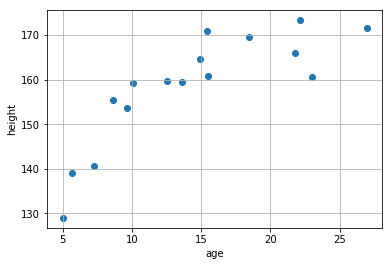

In [4]:
# サンプルデータ生成
np.random.seed(seed=1)
X_min, X_max, X_n = 4, 30, 16

# 年齢
X = 5 + 25 * np.random.rand(X_n)
# 身長 (計算式は何らかの分布になっている。意味はここでは気にしないこと)
T = 170 - 108 * np.exp(-0.2 * X) + 4 * np.random.randn(X_n)

plt.grid()
plt.xlabel("age")
plt.ylabel("height")
plt.scatter(X, T)

## モデル定義
機械学習には入力変数と目標変数の関係を数式でモデル化したものが必要となり、学習とはデータからモデルの最適なパラメータを推定する事と言える。

サンプルデータのモデルを定義してみる。サンプルデータを見る限り右肩上がりになっており、データに合わせた線を引くことで年齢から身長を推測できそうである。ここではモデル式は直線の形をしたものとして定義する。

$$
    y(x) = w_0x + w_1 \\
$$

## 二乗誤差関数


上の式のwをデータに合わせて最適化すれば良い線を引く事ができる。ここではデータへ合わせる指標をとして**平均二乗誤差(略称: MSE)**を定義。この値が最小になるwを見つけることで実測値との乖離の少ない線が求まる。

$$
    j = \frac{1}{N}\sum_{n=0}^{N-1}(y_n - t_n)^2 \\
$$

w0, w1の組合せごとの平均2乗誤差(2)を次のコードで求める。w0 = 3, w1 = 135 あたりで誤差最小になる事が分かる。

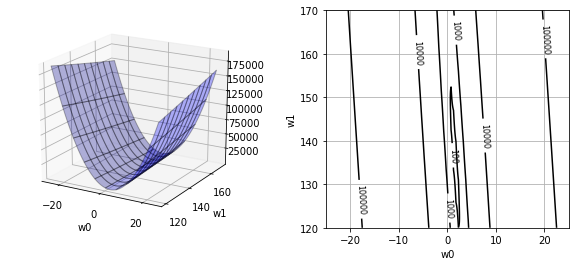

In [5]:
# 平均二乗誤差関数
def mse_line(w, x, t):
    y = x * w[0] + w[1]
    j = np.mean((y - t) ** 2, axis=0)
    return j

# パラメータ生成
w_n = 100
w0 = np.linspace(-25, 25, w_n)
w1 = np.linspace(120, 170, w_n)

# 平均二乗誤差導出
ww = np.meshgrid(w0, w1)
xx = np.repeat(X, w_n ** 2).reshape((X_n, w_n, w_n))
tt = np.repeat(T, w_n ** 2).reshape((X_n, w_n, w_n))
jj = mse_line(ww, xx, tt)

# グラフ 初期設定
plt.figure(figsize=(10, 4))
plt.subplots_adjust(wspace=0.3)

# グラフ (3D)
ax = plt.subplot(1, 2, 1, projection="3d")
ax.plot_surface(ww[0], ww[1], jj, rstride=10, cstride=10, alpha=0.3, color="blue", edgecolor="black")
ax.set_xlabel("w0")
ax.set_ylabel("w1")
ax.set_xticks([-20, 0, 20])
ax.set_yticks([120, 140, 160])
ax.view_init(20, -60)

# グラフ (等高線)
plt.subplot(1, 2, 2)
cont = plt.contour(ww[0], ww[1], jj, colors="black", levels=[100, 1000, 10000, 100000])
cont.clabel(fmt="%1.0f", fontsize=8)
plt.xlabel("w0")
plt.ylabel("w1")
plt.grid(True)

## 数値解
Jを最小化するWを求めるには、Wそれぞれの軸を偏微分すれば特定の点での傾きを出せることに着目する。この様なW0, W1の偏微分結果をベクトルとして束ねたものをJの **勾配** と呼ぶ。

$$
\begin{align}
    \frac{\partial j}{\partial w_0} &= \frac{2}{N}\sum_{n=0}^{N-1}(w_0x_n + w_1 - t_n)x_n \\
    \frac{\partial j}{\partial w_1} &= \frac{2}{N}\sum_{n=0}^{N-1}(w_0x_n + w_1 - t_n) \\
    \nabla{WJ} &=
        \left[\begin{array}{c}
            \frac{\partial j}{\partial w_0} \\
            \frac{\partial j}{\partial w_1}
        \end{array}\right]
\end{align}
$$

初期地点からループを回し、勾配ベクトルと逆方向へ進めば傾きが0になる地点 (jを最小化する地点) を見つけられる。この様な方法は勾配法と呼ばれ、求まる解は **数値解** と呼ばれる。

パラメータ最適化は、現在座標への勾配ベクトル加算を繰り返す事で行う。その差異、勾配ベクトルへ **学習率 (スカラ固定値)** を掛ける事で更新幅を調整する。学習率は大きすぎるとパラメータの収束が不安定になり、小さすぎると収束に時間がかかるため、程々への調整が必要。pythonではscipy.optimizeのminimize()関数を使用すると学習率などを勝手に調整しつつ最適値を導出できる。

In [4]:
def dmse_line(w, x, t):
    y = x * w[0] + w[1]
    dw_0 = np.mean((y - t) * x)
    dw_1 = np.mean((y - t))
    return np.array([dw_0, dw_1])

# 次の順番で各パラメータを渡している。
#  - 平均二乗誤差導出関数
#  - W初期値
#  - args=引数で指定している2関数に必要なW以外のパラメータ
#  - method="共役勾配法"
#  - jac=勾配ベクトル導出関数
opt.minimize(mse_line, (10, 10), args=(X, T), method="CG", jac=dmse_line)

     fun: 49.012195342938725
     jac: array([2.02469153e-11, 1.12443388e-12])
 message: 'Optimization terminated successfully.'
    nfev: 16
     nit: 4
    njev: 16
  status: 0
 success: True
       x: array([  1.55757515, 135.87192426])

## 解析解
数値解の限界として、Jが複雑な形状をしている際に本当の最適値を導出できず局所解に陥る可能性がある。直線モデルの場合、偏微分の方程式を解くことで、厳密な最適値を導出する事ができる。この様な解を解析解と呼ぶ。

$$
\begin{align}
    \frac{\partial j}{\partial w_0} &= \frac{2}{N}\sum_{n=0}^{N-1}(w_0x_n + w_1 - t_n)x_n = 0 \\
    \frac{\partial j}{\partial w_1} &= \frac{2}{N}\sum_{n=0}^{N-1}(w_0x_n + w_1 - t_n) = 0 \\
\end{align}
$$

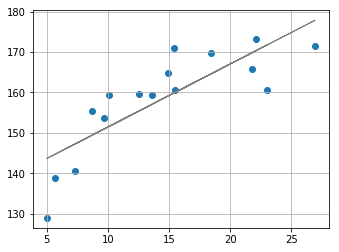

In [5]:
mx = np.mean(X)
mt = np.mean(T)
mtx = np.mean(T * X)
mxx = np.mean(X * X)

w0 = (mtx - mt * mx) / (mxx - mx ** 2)
w1 = mt - w0 * mx

plt.figure(figsize = (18, 4))
plt.subplot(1, 3, 1)
plt.grid()
plt.scatter(X, T)
plt.plot(X, w0 * X + w1, color="gray", linewidth=1)

# D次元線形回帰モデル
ここまでは入力変数が1つだった場合(1次元)を扱ってきた。ここからは入力変数が任意の数(D次元)の回帰モデルを考えていく。

## サンプルデータ
サンプルデータへ体重データを追加し、入力を2次元にする。

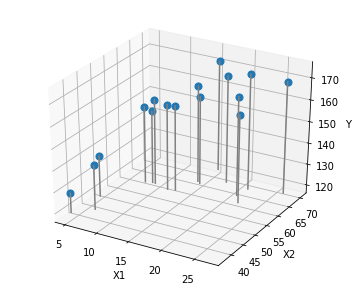

In [6]:
np.random.seed(1)
# 年齢
X0, X0_min, X0_max = X, 5, 30
# 体重 (追加データ)
X1, X1_min, X1_max = 23 * (T / 100)**2 + 2 * np.random.randn(X_n), 40, 75

def show_nd_data(ax):
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_zlabel("Y")
    ax.scatter(X0, X1, T, depthshade=False, s=50)
    for i in range(len(X0)):
        ax.plot([X0[i], X0[i]], [X1[i], X1[i]], [120, T[i]], color="gray")

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1, projection="3d")
show_nd_data(ax)

## 解析解
入力変数がd次元のデータを扱えるよう計算式を拡張する。変数とモデル(y)、損失関数(j)とその勾配ベクトルは次の様に定義する。

$$
    {\bf w} = \left[\begin{array}{c} w_0 \\ w_1 \\ \vdots \\ w_{d} \end{array}\right]
    \quad
    {\bf x}_n = \left[\begin{array}{c} w_0 \\ w_1 \\ \vdots \\ w_{d} \end{array}\right]
    \quad
    y({\bf x}_n) = {\bf w}^T{\bf x}_n \\
    j({\bf w}) = \frac{1}{N}\sum_{n=0}^N ({\bf w}^T{\bf x}_n - t_n)^2 \\
    \nabla j({\bf w}) = \frac{2}{N}\sum_{n=0}^N ({\bf w}^T{\bf x}_n - t_n){\bf x}_n^T
$$

二乗誤差関数を偏微分してwの値を求める。3行目からはシグマを消してXが横に次元数D、縦にデータ数Nだけ長さを持つ行列になっている。
$$
\begin{align}
    \sum_{n=0}^N ({\bf w}^T{\bf x}_n - t_n){\bf x}_n^T &= [0 \dots 0] \\
    {\bf w}^T \sum_{n=0}^N {\bf x}_n{\bf x}_n^T - \sum_{n=0}^N t_n{\bf x}_n^T  &= [0 \dots 0] \\
    {\bf w}^T \boldsymbol{X}^T\boldsymbol{X} - {\bf t}^T\boldsymbol{X}  &= [0 \dots 0] \\
    {\bf w}^T \boldsymbol{X}^T\boldsymbol{X} - {\bf t}^T\boldsymbol{X} &= [0 \dots 0] \\
    (\boldsymbol{X}^T\boldsymbol{X})^T{\bf w} &= \boldsymbol{X}^T{\bf t} \\
    \boldsymbol{X}^T\boldsymbol{X}{\bf w} &= \boldsymbol{X}^T{\bf t} \\
    {\bf w} &= (\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T{\bf t} \tag{1} \\
\end{align}
$$

上記の式は次の公式による変形を使用している。

$$
    \sum_{n=0}^N {\boldsymbol a_nb_n^T} = {\boldsymbol A^TB} \tag{2} \\
    ({\boldsymbol A} + {\boldsymbol B})^T = {\boldsymbol A}^T + {\boldsymbol B}^T \\
    ({\boldsymbol AB})^T = {\boldsymbol B}^T{\boldsymbol A}^T  \\
$$

式2を補足する。シグマで集計される長さは左側のベクトルでは横軸に、右側の行列では縦軸に展開させれば内積で代用できる。この場合、ベクトルxに対し、行列Xの添字は0番目が長さになる想定。故にベクトルが勝手に横ベクトルになっており、ここで転置の必要が生じる。

$$
    \sum_{n=0}^N {\bf a}_n {\bf b}_n^T =
    \left[\begin{array}{c|ccc}
        \\
        & g & h & i \\
        \hline
        a \\
        b \\
        c \\
    \end{array}\right]
    +
    \left[\begin{array}{c|ccc}
        \\
        & j & k & l \\
        \hline
        d \\
        e \\
        f \\
    \end{array}\right]
    =
    \left[\begin{array}{cc|ccc}
          & & g & h & i \\
          & & j & k & l \\
        \hline
        a & d \\
        b & e \\
        c & f \\
    \end{array}\right]
$$

式1を補足する。式中にある $(\boldsymbol{X}^TX)^{-1}X^T$ を **ムーアーペンローズの擬似逆行列** と呼ぶ。これはXに逆行列が無い場合に擬似的な逆行列として用いられ、実際にXと掛けると単位行列が得られるなど逆行列の様な性質がある。この式をXの逆行列として見なした場合、Wを出す式は次の方程式を解いた結果と見なす事もでき、スカラーの方程式を解く時と同じ様な形になっていることが分かる。

$$
\begin{align}
    {\bf t} &= \boldsymbol{X}{\bf w} \\
    \boldsymbol{X}^{-1} {\bf t} &= {\bf w}
\end{align}
$$

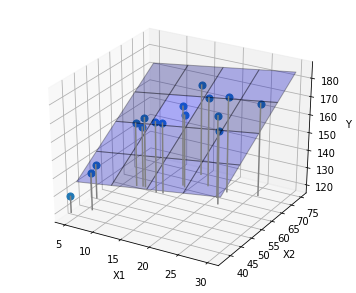

In [7]:
# D次元モデル
def nd_func(w, x):
    y = x @ w
    return y
# 平均二乗誤差
def mse_nd_func(x, t, w):
    y = nd_func(w, x)
    mse = np.mean((y - t) ** 2)
    return mse
# パラメータ導出
def fit_nd_func(x, t):
    x_inv = np.linalg.inv(x.T @ x) @ x.T
    w = x_inv @ t
    return w
# 回帰モデル可視化
def show_nd_func(w, ax):
    n = 5
    x0 = np.linspace(X0_min, X0_max, n)
    x1 = np.linspace(X1_min, X1_max, n)
    xx0, xx1 = np.meshgrid(x0, x1)
    x0 = xx0.flatten()
    x1 = xx1.flatten()
    x = np.array([x0, x1, np.ones(x0.size)]).T
    y = nd_func(w, x)

    yy = y.reshape(n ,n)
    ax.plot_surface(xx0, xx1, yy, rstride=1, cstride=1, alpha=0.3, color="blue", edgecolor="black")

# パラメータを導出
x = np.array([X0, X1, np.ones(X0.size)]).T
w = fit_nd_func(x, T)

# 可視化
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1, projection="3d")
show_nd_data(ax)
show_nd_func(w, ax)

# 線形基底関数モデル
話を1次元データに戻す。ここでは1次元データの各値をパラメータとした複数の分布をD次元用意し、各入力次元の重みを学習させる事で複雑な分布へ対応させる。これはD次元線形回帰モデルのX部分を、分布モデルが定義された関数Φ (**基底関数**) を通したものへ置き換える事で可能。つまり、D次元線形回帰モデルとして解く前にxへ基底関数による下処理を加える事で可能となる。

ここでは基底関数にガウス関数 (正規分布の原型) を用いる。ガウス関数には分布の中心(平均値)を示すuと分布の広がりを示すsがある。複数の分布平均を作成し、平均毎のガウス関数を作れば基底関数モデルが作れそうである。

$$
    \phi_j(x) = \exp\left\{ -\frac{(x - u_j)^2}{2s^2} \right\} \\
    {\bf w} = (\boldsymbol{\phi}^T\boldsymbol{\phi})^{-1}\boldsymbol{\phi}^T {\bf t}
$$

## 解析解

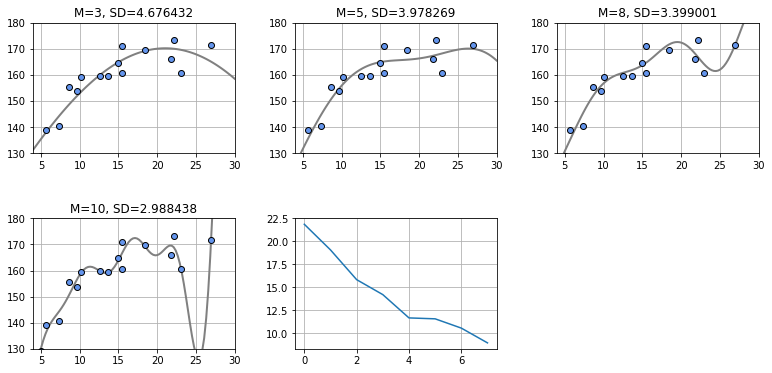

In [80]:
def gauss_basis(x, m):
    # xを各基底関数用にD次元ベクトル化
    x = x.reshape(*x.shape, 1)
    
    # 各基底関数の中心を(m - 1)個用意。m個目はバイアス項
    mu = np.linspace(5, 30, m - 1)
    mu = np.append(mu, 0)
    
    # 各基底関数としてガウス分布を使用。muは分布の中心、sは分布の幅
    s = mu[1] - mu[0]
    x_basis = np.exp(-(x - mu) ** 2 / (2 * s ** 2))
    
    # D次元ベクトルの右端はバイアス項。固定値1
    x_basis = x_basis.T
    x_basis[-1] = 1
    x_basis = x_basis.T
    return x_basis
def show_gauss_func(w):
    x = np.linspace(X_min, X_max, 100)
    xx = gauss_basis(x, w.size)
    y = nd_func(w, xx)
    plt.plot(x, y, c=[.5, .5, .5], lw=2)

plt.figure(figsize=(13, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
for i, m in enumerate([3, 5, 8, 10]):
    # 1次元のxをD次元化し、基底関数で下処理したものをD次元線形回帰モデルで解く
    x = gauss_basis(X, m)
    w = fit_nd_func(x, T)
    mse = mse_nd_func(x, T, w)
    
    # 可視化
    plt.subplot(2, 3, i + 1)
    show_gauss_func(w)
    plt.plot(X, T, marker='o', linestyle='None', color='cornflowerblue', markeredgecolor='black')
    plt.xlim(X_min, X_max)
    plt.ylim(130, 180)
    plt.title("M={0:d}, SD={1:1f}".format(m, np.sqrt(mse)))
    plt.grid()

# 次元数を増やし、柔軟性を上げる
mls = list()
for i, m in enumerate(range(3, 11)):
    x = gauss_basis(X, m)
    w = fit_nd_func(x, T)
    mse = mse_nd_func(x, T, w)
    mls.append(mse)
plt.subplot(2, 3, 5)
plt.plot(np.arange(len(mls)), mls)
plt.grid()

## オーバーフィッティングの問題
線形基底関数モデルを用いれば複雑な分布のデータも上手く扱えそうに見える。しかし、基底関数を増やしていくと分布はデータが無い区間で形状が不自然になったりする。これでは実データで使い始めた際に精度が出ない (**汎化性能**が低い) 。しかしこれでも平均二乗誤差は減少していく。これは訓練データへの過剰適応が起きており、オーバーフィッティング (過学習) と呼ぶ。

次のコードではデータを訓練データとテストデータに分け、訓練データで学習を行い、テストデータで平均二乗誤差を計算する。するとテストデータとの誤差が増加していることが分かる。

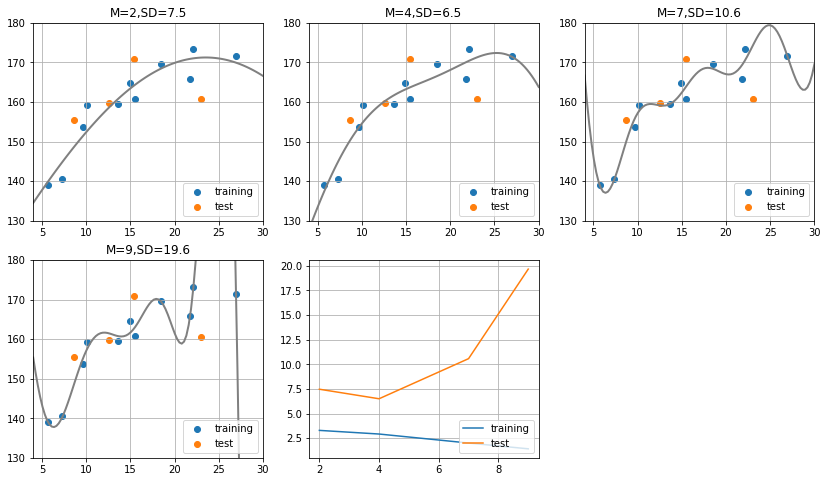

In [204]:
M = [2, 4, 7, 9]
X_test = X[:int(X_n / 4 + 1)]
T_test = T[:int(X_n / 4 + 1)]
X_train = X[int(X_n / 4 + 1):]
T_train = T[int(X_n / 4 + 1):]

def training_and_checkmodel(testX, testY, trainingX, trainingY, m):
    W = fit_gauss_func(trainingX, trainingY, m)
    mse_training = mse_gauss_func(X_train, T_train, W)
    mse_test = mse_gauss_func(X_test, T_test, W)
    
    plt.title("M={0:d},SD={1:.1f}".format(m, np.sqrt(mse_test)))
    plt.scatter(trainingX, trainingY, label='training')
    plt.scatter(testX, testY, label='test')
    show_gauss_func(W)
    
    plt.xlim(X_min, X_max)
    plt.ylim(130, 180)
    plt.grid(True)
    plt.legend(loc='lower right')
    return np.sqrt(mse_training), np.sqrt(mse_test)

mseLst = list()
plt.figure(figsize=(14,8))
for i, m in enumerate(M):
    plt.subplot(2, 3, i + 1)
    mseLst.append(training_and_checkmodel(X_test, T_test, X_train, T_train, m))

mse_train, mse_test = np.array(mseLst).T
plt.subplot(2, 3, len(M) + 1)
plt.plot(M, mse_train, label='training')
plt.plot(M, mse_test, label='test')
plt.grid(True)
plt.legend(loc='lower right')

Text(0.5,1,'w0=169.0, w1=113.7, w=0.2, SD=3.86')

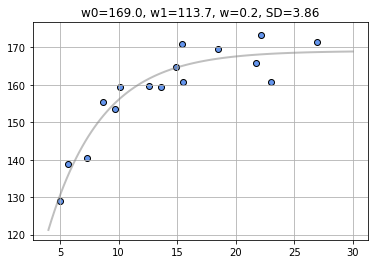

In [290]:
import scipy.optimize as opt

def model_A(x, w):
    y = w[0] - w[1] * np.exp(-w[2] * x)
    return y
def show_model_A(w):
    xb = np.linspace(X_min, X_max, 100)
    y = model_A(xb, w)
    plt.plot(xb, y, c="#80808080", lw=2)
def mse_model_A(w, x, t):
    y = model_A(x, w)
    mse = np.mean((y - t)**2)
    return mse
def fit_model_A(w_init, x, t):
    res1 = opt.minimize(mse_model_A, w_init, args=(x, t), method="powell")
    return res1.x

W_init = [100, 0, 0]
W = fit_model_A(W_init, X, T)
show_model_A(W)
mse = mse_model_A(W, X, T)
plt.scatter(X, T, marker="o", color="cornflowerblue", edgecolor="black")
# plt.xlim(X_min, X_max)
plt.grid()
plt.title("w0={0:.1f}, w1={1:.1f}, w={2:.1f}, SD={3:.2f}".format(*W, np.sqrt(mse)))